In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 불러오기

In [3]:
# import urllib3
# urllib3.disable_warnings()

# #tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

# ds_train, ds_info = tfds.load(
#     'cats_vs_dogs',
#     split=tfds.Split.TRAIN,
#     with_info=True
# )

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# # 데이터의 개수도 확인해 봅시다. 
# print(tf.data.experimental.cardinality(ds_train))

In [7]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


# 데이터 구성 알아보기

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

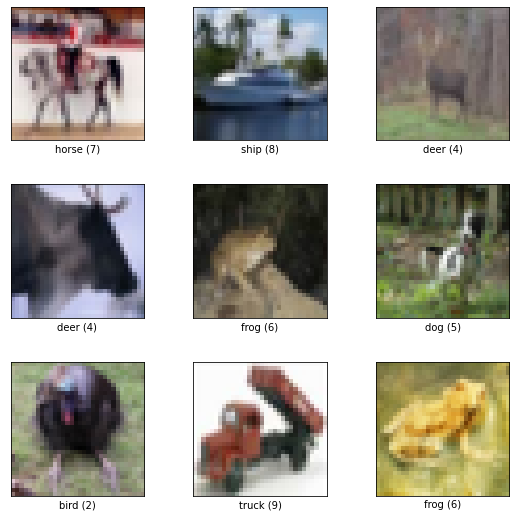

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

# 블록 구성하기

## ResNet 구성 살펴보기
- ResNet34와 ResNet50 모두 conv block이라는 블록 구조로 각 3,4,6,3씩 반복해서 쌓여 있는 형태

### ResNet-34의 경우
- block은 3x3 kernel인 Convolution layer로만 구성

### ResNet-50의 경우
- 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가짐


ResNet을 구성하기 위한 기본 basic block 구성하기

In [11]:
def ConvLayer(x, kernel, channel, stride):
    h = keras.layers.Conv2D(filters = channel, kernel_size = kernel, strides=stride, padding="same")(x)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Activation(activations.relu)(h)
    return h


In [12]:
# def  ShortcutLayer(x, kernel, channel, stride, residual_x):
#     h = keras.layers.Conv2D(filters = channel, kernel_size = kernel, strides=1, padding="same")(x)
#     h = keras.layers.BatchNormalization()(h)

#     if stride == 2:
#         residual_x = keras.layers.Conv2D(filters = channel, kernel_size = 1, strides=stride, padding="same")(residual_x)
#         residual_x = keras.layers.BatchNormalization()(residual_x)
        
#     #shortcut
#     h = keras.layers.Add()([h, residual_x])
#     #activation
#     h = keras.layers.Activation(activations.relu)(h)
#     return h


In [13]:
def BasicBlockResNet34(x, channel, stride, isPlan=False):
    residual_x = x
    h = keras.layers.Conv2D(filters = channel, kernel_size = 3, strides=stride, padding="same")(x)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Activation(activations.relu)(h)

    h = keras.layers.Conv2D(filters = channel, kernel_size = 3, strides=1, padding="same")(h)
    h = keras.layers.BatchNormalization()(h)

    if isPlan == False and stride == 2:
        residual_x = keras.layers.Conv2D(filters = channel, kernel_size = 1, strides=stride, padding="same")(residual_x)
        residual_x = keras.layers.BatchNormalization()(residual_x)
        #shortcut
        h = keras.layers.Add()([h, residual_x])
    
    #activation
    h = keras.layers.Activation(activations.relu)(h)

    return h

In [14]:
def BasicBlockResNet50(x, stride, channel,first=False, isPlan = False):
    #ResNet50일 경우 
    #ConvLayer, ConvLayer, ShortLayer로 진행
    residual_x = x
    ch1 = channel
    ch2 = channel * 4
    # Conv1 1x1 64
    h = keras.layers.Conv2D(filters = ch1, kernel_size = 1, strides=stride, padding="same")(x)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Activation(activations.relu)(h)

    #Conv2 3x3 64
    h = keras.layers.Conv2D(filters = ch1, kernel_size = 3, strides=1, padding="same")(h)
    h = keras.layers.BatchNormalization()(h)
    h = keras.layers.Activation(activations.relu)(h)

    #Conv3 1x1 (64 * 4)
    #shortcut
    h = keras.layers.Conv2D(filters = ch2, kernel_size = 1, strides=1, padding="same")(h)
    h = keras.layers.BatchNormalization()(h)

    if not isPlan:
        if  first:
            residual_x = keras.layers.Conv2D(filters = ch2, kernel_size = 1, strides=stride, padding="same")(residual_x)
            residual_x = keras.layers.BatchNormalization()(residual_x)
        #shortcut
        h = keras.layers.Add()([h, residual_x])
    #activation
    h = keras.layers.Activation(activations.relu)(h)
    
    return h

In [15]:
def build_resnet(x,isResNet50=False):
    loop_list = [3,4,6,3]
    #Conv2까지는 stride=1로 동일
    #Conv3~Conv5까지 가장 처음 layer 구성할 때 strid=2로 시작함, 이후에는 stride=2로 구성
    
    ResNet_channel = [64,128,256,512]
    # 34는 channel 값 그대로 사용
    #ResNet 50일 경우 한 block 당 3개의 layer 있음 , 마지막 layer는 해당 block의 channel *4의 값을 가짐


    #ResNet34, ResNet50 모두 Conv1과 Conv2 전에 MaxPooling 까지는 동일함
    #Conv1
    h = ConvLayer(x,7,64,2)
    #Conv2_MaxPooling 단계
    h = keras.layers.MaxPooling2D(pool_size=(2,2),strides=2)(h)
    #residual_x = h

    #해당 loop_num에 따라 반복하여 Layer 구성
    #Conv2 basic block 진행
    for i in range(loop_list[0]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,1,ResNet_channel[0] ,True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[0])
        else:
            h = BasicBlockResNet34(h,ResNet_channel[0],1)
        


    #Conv3 sride=2
    for i in range(loop_list[1]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[1] ,True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[1])
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[1],2)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[1],1)
    
    #Conv4 sride=2
    for i in range(loop_list[2]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[2] ,True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[2])
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[2],2)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[2],1)

    #Conv5 sride=2
    for i in range(loop_list[3]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[3] ,True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[3])
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[3],2)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[3],1)

    
    #averge Pooling
    h = keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(h)
    #Fully Layer    
    h =  keras.layers.Flatten()(h)
    
    h = keras.layers.Dense(2, activation='softmax')(h) #multi-class

    return h



In [16]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))
resnet_block_output = build_resnet(resnet_input_layer)
resnet34_model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  
resnet34_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [17]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))
resnet_block_output = build_resnet(resnet_input_layer, True)
resnet50_model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 16, 16, 64)  256         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_33 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_36[0]

In [18]:
from os import truncate
def build_plainnet(x,isResNet50=False):
    loop_list = [3,4,6,3]
    #Conv2까지는 stride=1로 동일
    #Conv3~Conv5까지 가장 처음 layer 구성할 때 strid=2로 시작함, 이후에는 stride=2로 구성
    
    ResNet_channel = [64,128,256,512]
    # 34는 channel 값 그대로 사용
    #ResNet 50일 경우 한 block 당 3개의 layer 있음 , 마지막 layer는 해당 block의 channel *4의 값을 가짐


    #ResNet34, ResNet50 모두 Conv1과 Conv2 전에 MaxPooling 까지는 동일함
    #Conv1
    h = ConvLayer(x,7,64,2)
    #Conv2_MaxPooling 단계
    h = keras.layers.MaxPooling2D(pool_size=(2,2),strides=2)(h)
    #residual_x = h

    #해당 loop_num에 따라 반복하여 Layer 구성
    #Conv2 basic block 진행
    for i in range(loop_list[0]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,1,ResNet_channel[0] ,True, True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[0],False, True)
        else:
            h = BasicBlockResNet34(h,ResNet_channel[0],1, True)
        


    #Conv3 sride=2
    for i in range(loop_list[1]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[1] ,True, True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[1],False, True)
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[1],2, True)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[1],1, True)
    
    #Conv4 sride=2
    for i in range(loop_list[2]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[2] ,True, True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[2],False, True)
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[2],2, True)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[2],1, True)

    #Conv5 sride=2
    for i in range(loop_list[3]):
        if isResNet50:
            if i== 0 :
                h = BasicBlockResNet50(h,2,ResNet_channel[3] ,True, True)
            else:
                h = BasicBlockResNet50(h,1,ResNet_channel[3],False, True)
        else:
            #처음은 stride=2로 구성
            if i==0:
                h = BasicBlockResNet34(h,ResNet_channel[3],2, True)
            else:#나머지는 stride=1로 구성
                h = BasicBlockResNet34(h,ResNet_channel[3],1, True)

    
    #averge Pooling
    h = keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(h)
    #Fully Layer    
    h =  keras.layers.Flatten()(h)
    
    h = keras.layers.Dense(2, activation='softmax')(h) #multi-class

    return h



In [19]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))
resnet_block_output = build_plainnet(resnet_input_layer)
resnet34PlanModel = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  
resnet34PlanModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_89 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_89 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 8, 8, 64)          3692

In [20]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))
resnet_block_output = build_plainnet(resnet_input_layer, True)
resnet50PlanModel = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  
resnet50PlanModel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_122 (Conv2D)         (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_122 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 8, 8, 64)          4160

# Ablation Study
cat vs dog 데이터 사용하여 비교

In [21]:
BATCH_SIZE = 256
EPOCH = 10

In [22]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [23]:
ds_train, ds_test

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [24]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [25]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [26]:
ds_info.features["label"].num_classes

2

In [27]:
ds_info.features["label"].names

['cat', 'dog']

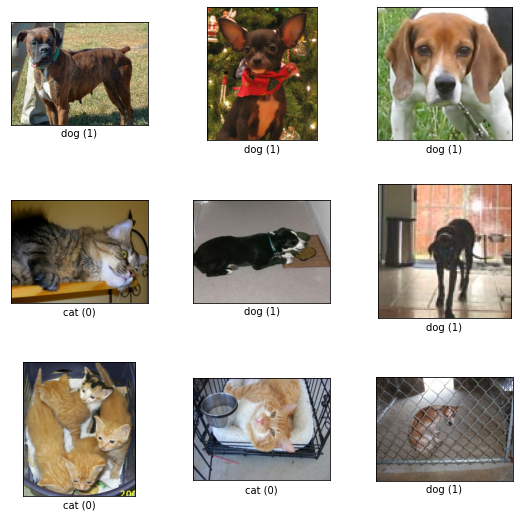

In [28]:
fig = tfds.show_examples(ds_train, ds_info)

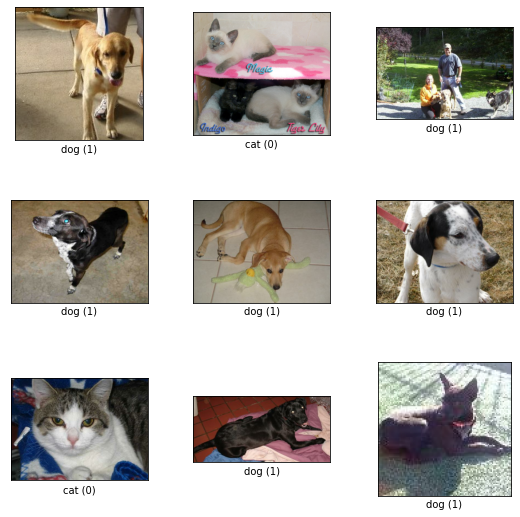

In [29]:
fig = tfds.show_examples(ds_test, ds_info)

### Normalization
이미지 데이터 정규화

In [30]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #image = tf.image.resize(image, [32, 32])
    #return tf.cast(image, tf.float32) / 255., label
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [31]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [32]:
ds_train1 = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE)
ds_test1 = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [33]:
ds_train1,ds_test1

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## ResNet34 vs Plan34

In [34]:
resnet34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [35]:
history_34 = resnet34_model.fit(
    ds_train1,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
72/72 [==============================] - 97s 721ms/step - loss: 0.7652 - accuracy: 0.5047 - val_loss: 0.6936 - val_accuracy: 0.4878
Epoch 2/10
72/72 [==============================] - 49s 696ms/step - loss: 0.7313 - accuracy: 0.5063 - val_loss: 0.6935 - val_accuracy: 0.4957
Epoch 3/10
72/72 [==============================] - 50s 703ms/step - loss: 0.7217 - accuracy: 0.5072 - val_loss: 0.6933 - val_accuracy: 0.4991
Epoch 4/10
72/72 [==============================] - 51s 717ms/step - loss: 0.7153 - accuracy: 0.5097 - val_loss: 0.6935 - val_accuracy: 0.5132
Epoch 5/10
72/72 [==============================] - 54s 762ms/step - loss: 0.7051 - accuracy: 0.5210 - val_loss: 0.6948 - val_accuracy: 0.4961
Epoch 6/10
72/72 [==============================] - 57s 801ms/step - loss: 0.7019 - accuracy: 0.5228 - val_loss: 0.6959 - val_accuracy: 0.4989
Epoch 7/10
72/72 [==============================] - 49s 690ms/step - loss: 0.6972 - accuracy: 0.5270 - val_loss: 0.6929 - val_accuracy: 0.5116

In [36]:
resnet34PlanModel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [37]:
historyplan_34 = resnet34PlanModel.fit(
    ds_train1,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
72/72 [==============================] - 88s 704ms/step - loss: 0.7754 - accuracy: 0.4986 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 2/10
72/72 [==============================] - 50s 699ms/step - loss: 0.7307 - accuracy: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.5141
Epoch 3/10
72/72 [==============================] - 50s 707ms/step - loss: 0.7240 - accuracy: 0.5084 - val_loss: 0.6934 - val_accuracy: 0.5059
Epoch 4/10
72/72 [==============================] - 51s 720ms/step - loss: 0.7115 - accuracy: 0.5137 - val_loss: 0.6953 - val_accuracy: 0.4996
Epoch 5/10
72/72 [==============================] - 52s 730ms/step - loss: 0.7077 - accuracy: 0.5104 - val_loss: 0.6945 - val_accuracy: 0.4980
Epoch 6/10
72/72 [==============================] - 57s 808ms/step - loss: 0.7041 - accuracy: 0.5106 - val_loss: 0.6938 - val_accuracy: 0.4992
Epoch 7/10
72/72 [==============================] - 49s 696ms/step - loss: 0.6992 - accuracy: 0.5163 - val_loss: 0.6948 - val_accuracy: 0.5111

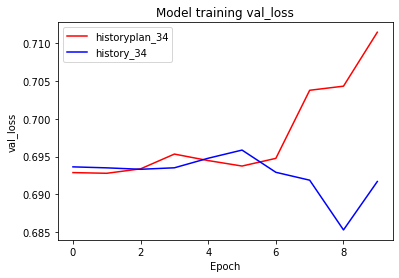

In [50]:
import matplotlib.pyplot as plt

plt.plot(historyplan_34.history['val_loss'], 'r')
plt.plot(history_34.history['val_loss'], 'b')
plt.title('Model training val_loss')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['historyplan_34', 'history_34'], loc='upper left')
plt.show()

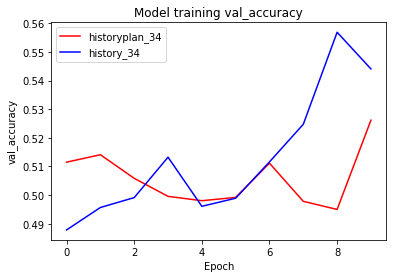

In [39]:

plt.plot(historyplan_34.history['val_accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.title('Model training val_accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('Epoch')
plt.legend(['historyplan_34', 'history_34'], loc='upper left')
plt.show()

### val_loss와 Val_acc 값 비교 분석

ResNet34와 Plan34의 val_loss의 값을 그래프로 시각화한 결과 처음에는 Resnet34와 Plan34의 loss값이 비슷하게 시작되었지만 epoch이 증가하면서 ResNet34의 loss의 값은 감소 Plan34는 증가하는 것을 볼 수 있다.
<br/>
ResNet34와 Plan34의 Val_acc값을 시각화한 결과 처음에는 Plan34의 val_acc가 높았지만 epoch수가 증가하면서 ResNet34의 val_acc값이 Plan34의 val_acc보다 훨씬 높은 것을 볼 수 있다.
<br/>
이와 같은 결과를 보면 Plan34의 경우 epoch수가 증가하면서 acc, loss 값이 처음에는 완만하게 학습되고 있지만 epoch=6을 기점으로 loss의 값은 증가 acc값은 감소하는 것을 볼 수 있다. 이는 Plan34의 layer가 깊게 구성되어 있어 많은 학습이 진행되어도 가중치들이 업데이트가 제대로 되지 않아 정확도의 값이 이전에 비해 떨어지는 현상이 나타난다.
<br/>
그에 비해 ResNet34의 경우 eppch=6을 기준으로 val_acc값은 증가하고 val_loss의 값은 감소하는 형태가 나타난다. 이는 깊은 레이어를 가지고 있어도 shortcut(잔차학습)을 통해 원홯하게 학습을 진행되고 있다는 것을 볼 수 있다.

## ResNet50 vs Plan50

In [45]:
resnet50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50_model.fit(
    ds_train1,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


72/72 [==============================] - 93s 715ms/step - loss: 0.7531 - accuracy: 0.5434 - val_loss: 1.1014 - val_accuracy: 0.5197
Epoch 2/10
72/72 [==============================] - 51s 710ms/step - loss: 0.7353 - accuracy: 0.5521 - val_loss: 0.8933 - val_accuracy: 0.5241
Epoch 3/10
72/72 [==============================] - 52s 727ms/step - loss: 0.7355 - accuracy: 0.5513 - val_loss: 1.0081 - val_accuracy: 0.5289
Epoch 4/10
72/72 [==============================] - 58s 812ms/step - loss: 0.7315 - accuracy: 0.5630 - val_loss: 0.9517 - val_accuracy: 0.5093
Epoch 5/10
72/72 [==============================] - 53s 746ms/step - loss: 0.7245 - accuracy: 0.5652 - val_loss: 0.8618 - val_accuracy: 0.5419
Epoch 6/10
72/72 [==============================] - 56s 783ms/step - loss: 0.7082 - accuracy: 0.5780 - val_loss: 0.7434 - val_accuracy: 0.5546
Epoch 7/10
72/72 [==============================] - 50s 704ms/step - loss: 0.7003 - accuracy: 0.5800 - val_loss: 0.7838 - val_accuracy: 0.5562
Epoch 8/10

In [46]:
resnet50PlanModel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

historyplan_50 = resnet50PlanModel.fit(
    ds_train1,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test1,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


72/72 [==============================] - 92s 709ms/step - loss: 0.7118 - accuracy: 0.5097 - val_loss: 0.7359 - val_accuracy: 0.4948
Epoch 2/10
72/72 [==============================] - 50s 707ms/step - loss: 0.7111 - accuracy: 0.5030 - val_loss: 0.8190 - val_accuracy: 0.4935
Epoch 3/10
72/72 [==============================] - 51s 712ms/step - loss: 0.7116 - accuracy: 0.5047 - val_loss: 0.7854 - val_accuracy: 0.5048
Epoch 4/10
72/72 [==============================] - 51s 723ms/step - loss: 0.7071 - accuracy: 0.5057 - val_loss: 0.7588 - val_accuracy: 0.5080
Epoch 5/10
72/72 [==============================] - 53s 739ms/step - loss: 0.7081 - accuracy: 0.4992 - val_loss: 0.8737 - val_accuracy: 0.4928
Epoch 6/10
72/72 [==============================] - 55s 780ms/step - loss: 0.7069 - accuracy: 0.5045 - val_loss: 0.9440 - val_accuracy: 0.5204
Epoch 7/10
72/72 [==============================] - 50s 709ms/step - loss: 0.7082 - accuracy: 0.5044 - val_loss: 1.0683 - val_accuracy: 0.4957
Epoch 8/10

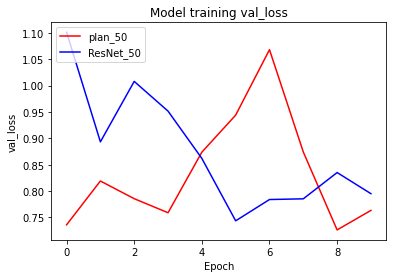

In [52]:
import matplotlib.pyplot as plt

plt.plot(historyplan_50.history['val_loss'], 'r')
plt.plot(history_50.history['val_loss'], 'b')
plt.title('Model training val_loss')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['plan_50', 'ResNet_50'], loc='upper left')
plt.show()

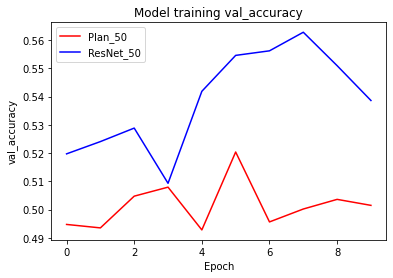

In [53]:

plt.plot(historyplan_50.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model training val_accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('Epoch')
plt.legend(['Plan_50', 'ResNet_50'], loc='upper left')
plt.show()

## ResNet50과 Plan50 val_acc와 val_loss 비교 분석
ResNet50과 Plan50의 결과 또한 이전의 ResNet34, Plan34와 비슷한 현상이 나타난다는 것을 시각화를 통해 볼 수 있다.
<br/>
ResNet50의 경우 ResNet34에 비해 더 깊은 Layer를 구성하여 학습하였기 때문에 epoch=3를 기점으로 Plan50의 loss와 acc값을 확인해보면 가중치들이 업데이트가 제대로 되지 않아 정확도의 값이 떨어지는 현상이 나타나는 것을 볼 수 있다.

# Ablation Study

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


epoch=10로 하여 val_acc 기준으로 Ablation Study 작성한 결과

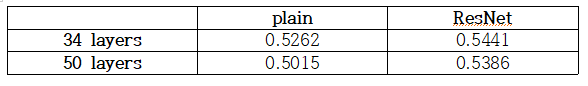

In [56]:
import os
from IPython.display import Image
#img_path = os.getenv('HOME')+'/aiffel/camera_sticker/ReNet_model/ResNet결과.png'
image_path = "/content/drive/MyDrive/아이펠/GoingDeeper/ResNet 구성하기/ResNet결과.png"
Image(image_path)

# 회고
처음으로 논문을 보면서 Deep Learning Model을 구현하는 시간이였다. 대부분의 자료와 논문이 영어로 작성되어 있어 해석하고 이해하는데 생각보다 많은 시간이 걸렸다. 
<br/>
ResNet Model이 어떻게 동작하는지에 대한 이론적으로는 이해가 되었지만 처음으로 코드로 구현하고 모듈화 하는 과정에서 어떻게 구성해야 조금 더 좋게 모듈화할 수 있을까에 대해 고민하면서 코드를 구현하느라 ResNet 모델 과정이 생각보다 오래 걸렸다.
<br/>
하지만 ResNet 모델을 직접 구현하면서 딥러닝이 동작되는 전반적인 과정과 stride와 kernel이 적용되었을 때 데이터가 어떻게 변화되는지에 대해 조금 더 구체적으로 알게되는 시간이었다.